In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr;xr.set_options(display_style='text') 


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)
from tools.wrfHrTools import *
from perlmutterNotebooks.rfpreprocessing import *

from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns

# Training a random forest

In [3]:
W10S300 = Simulation('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/',1635,3,out=False,pout=True)
#W10S296 = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/',1635,3,'1970010100-1970090900')

In [4]:
sample_rce = make_df(W10S300,-3000,-5000,variables='thetae',dt=24*8,p1=24,p2 = 24)

In [5]:
#X_train, X_test, y_train, y_test = train_test_split(features_df,outputs_df['precip'],test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(sample_rce.drop('precip',axis=1),sample_rce['precip'],test_size=0.2)




In [6]:
%%time
rf = RandomForestRegressor(max_features=20 ,n_estimators = 10,verbose=True , min_samples_leaf= 20,n_jobs=10, min_samples_split = 5)
rf.fit(X_train, y_train)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   12.4s remaining:   49.5s


CPU times: user 2min 4s, sys: 80.5 ms, total: 2min 4s
Wall time: 13.1 s


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   12.9s finished


RandomForestRegressor(max_features=20, min_samples_leaf=20, min_samples_split=5,
                      n_estimators=10, n_jobs=10, verbose=True)

In [7]:
pred = rf.predict(X_test)
print('MAE: ',mean_absolute_error(y_test, pred))
print('MSE: ',mean_squared_error( y_test, pred))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


MAE:  41.49363582864861
MSE:  4625.29820779722


In [8]:
importances = list(rf.feature_importances_)
feature_list = list(X_test.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

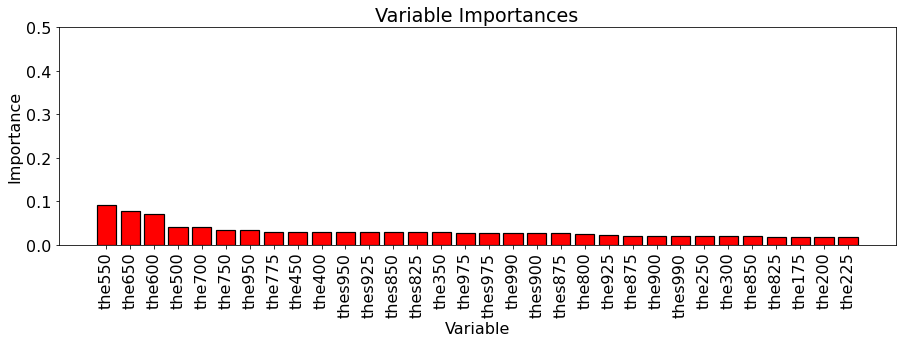

In [9]:
#plot the feature importance 
plt.figure(figsize=(15,4))
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, sorted(importances , reverse = True), orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2 )
# Tick labels for x axis
plt.xticks(x_values, list(np.array(feature_importances)[:,0]), rotation='vertical')
plt.ylim((0,0.5))
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Testing accuracy vs B_L

In [10]:
from scipy.optimize import curve_fit
func = lambda x,a,b : np.exp(a*x+b)


In [11]:
bl_rce,pr_rce = get_blpr(W10S300,-3000,-5000,t1=4000,dt=24*4)

In [12]:
c,m = get_binned(bl_rce,pr_rce,np.linspace(-1,0.2,101))

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


In [13]:
idx = ~np.isnan(m)
c=c[idx];m=m[idx]

In [14]:

n=88
popt,_ = curve_fit(func,c[:n],m[:n])
fit = lambda x : np.exp(popt[0]*x+popt[1])

(-1.0, 100.0)

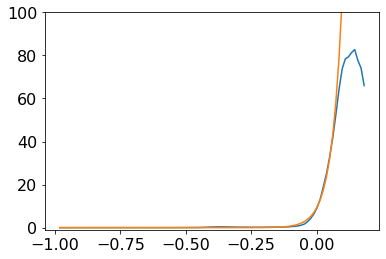

In [15]:
plt.plot(c,m)
plt.plot(c,fit(c))
plt.ylim(-1,100)

[18.39143192  2.45275637]


(-1.0, 100.0)

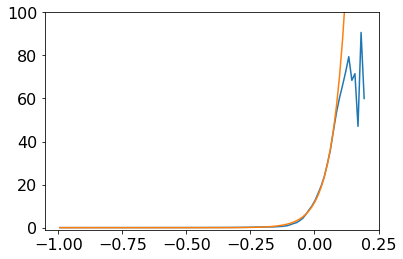

In [25]:
bl_rce,pr_rce = get_blpr(W10S300,-3000,-5000,t1=4000,dt=24*4,bltype='700_900')
c,m = get_binned(bl_rce,pr_rce,np.linspace(-1,0.2,101))
idx = ~np.isnan(m)
c=c[idx];m=m[idx]

n=90
poptsh,_ = curve_fit(func,c[:n],m[:n])
print(poptsh)
fitsh = lambda x : np.exp(poptsh[0]*x+poptsh[1])

plt.plot(c,m)
plt.plot(c,fitsh(c))
plt.ylim(-1,100)

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


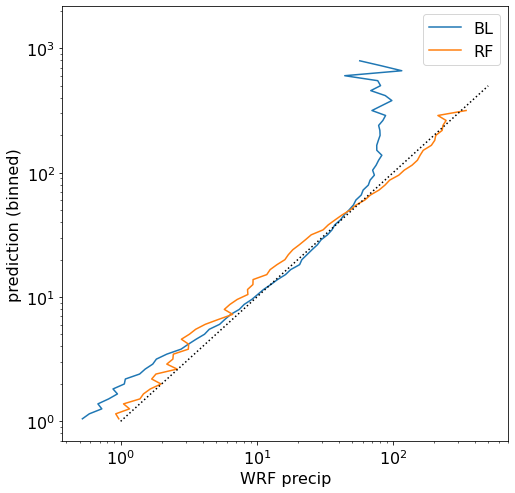

In [16]:
plot_1to1([(fit(bl_rce),pr_rce,'BL'),(pred,y_test,'RF')],log=True)

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  plt.xscale('log');plt.yscale('log')


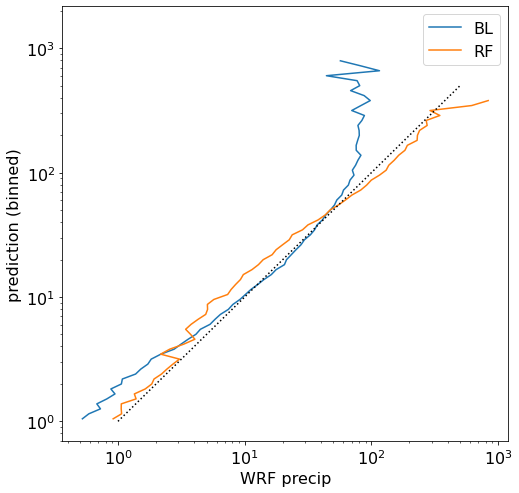

In [20]:
plot_1to1([(fit(bl_rce),pr_rce,'BL'),(pred,y_test,'RF')],log=True)

# Split RCE / mountain / downstream

In [17]:
test_mtn = make_df(W10S300,-100,-400  ,t1=4000,dt=24*4,variables='thetae',p1=24,p2 = 24)
test_lee = make_df(W10S300,800,200    ,t1=4000,dt=24*4,variables='thetae',p1=24,p2 = 24)

pred_rce = pred
pred_mtn = rf.predict(test_mtn.drop('precip',axis=1))
pred_lee = rf.predict(test_lee.drop('precip',axis=1))
true_rce = y_test
true_mtn = test_mtn['precip']
true_lee = test_lee['precip']

ERROR! Session/line number was not unique in database. History logging moved to new session 4311


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [18]:
bl_mtn,pr_mtn = get_blpr(W10S300,-100,-400  ,t1=4000,dt=24*4)
bl_lee,pr_lee = get_blpr(W10S300,800,200    ,t1=4000,dt=24*4)

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


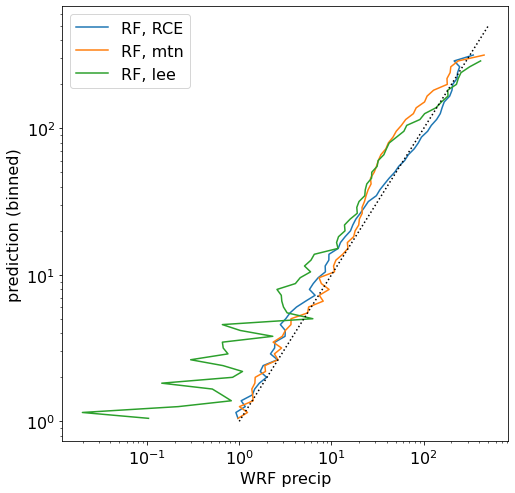

In [19]:
plot_1to1([(pred_rce,true_rce,'RF, RCE'),(pred_mtn,true_mtn,'RF, mtn'),(pred_lee,true_lee,'RF, lee')],log=True)

In [26]:
bl_abv,pr_abv = get_blpr(W10S300,0,-100  ,t1=4000,dt=24*12)
test_abv = make_df(W10S300,0,-100    ,t1=4000,dt=24*12)
pred_abv = rf.predict(test_abv.drop('precip',axis=1))
true_abv = test_abv['precip']

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


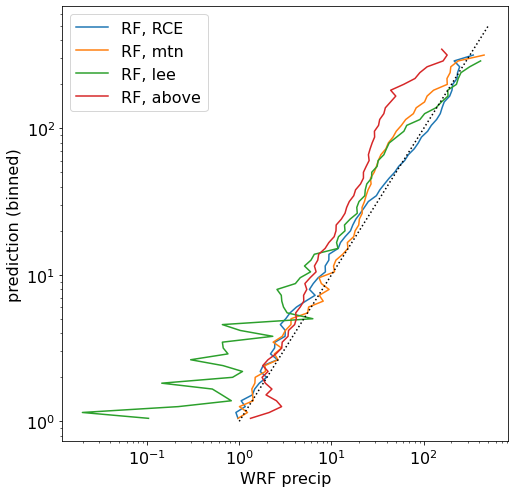

In [22]:
plot_1to1([(pred_rce,true_rce,'RF, RCE'),(pred_mtn,true_mtn,'RF, mtn'),(pred_lee,true_lee,'RF, lee'),(pred_abv,true_abv,'RF, above')],log=True)

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


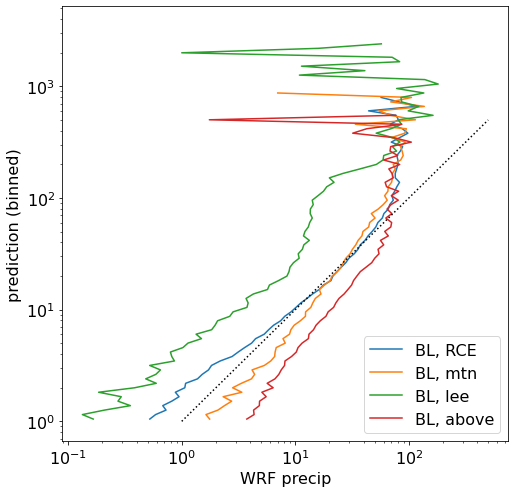

In [24]:
plot_1to1([(fit(bl_rce),pr_rce,'BL, RCE'),
           (fit(bl_mtn),pr_mtn,'BL, mtn'),
           (fit(bl_lee),pr_lee,'BL, lee'),
           (fit(bl_abv),pr_abv,'BL, above')
          ],log=True)

In [30]:
blsh_abv,pr_abv = get_blpr(W10S300,0,-100  ,t1=4000,dt=24*12,bltype='700_900')
blsh_rce,pr_rce = get_blpr(W10S300,-4000,-4300,t1=4000,dt=24*4,bltype='700_900')
blsh_mtn,pr_mtn = get_blpr(W10S300,-100,-400  ,t1=4000,dt=24*4,bltype='700_900')
blsh_lee,pr_lee = get_blpr(W10S300,800,200    ,t1=4000,dt=24*4,bltype='700_900')

/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)
/global/homes/q/qnicolas/perlmutterNotebooks/rfpreprocessing.py:69: RuntimeWarning: invalid value encountered in true_divide
  return bin_centers,(bin_sums/counts)


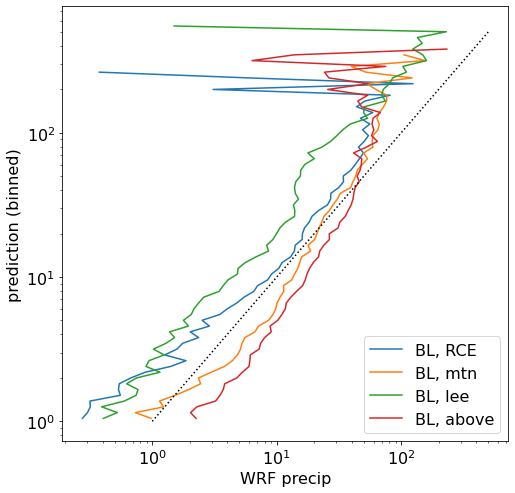

In [31]:
plot_1to1([(fitsh(blsh_rce),pr_rce,'BL, RCE'),
           (fitsh(blsh_mtn),pr_mtn,'BL, mtn'),
           (fitsh(blsh_lee),pr_lee,'BL, lee'),
           (fitsh(blsh_abv),pr_abv,'BL, above')
          ],log=True)